## Descriptions:
Imputation of missing ESI and HW - should use a fuller cohort (see changes)
- Impute HW using some demographics variables (use *cohort2*, old - more data for HW)
- Impute ESI, use cohort3 to get the 1st set of VS 
- One-hot encoding for race and gender
- To be combined with all other vital related information to form the simple dataset

**Changes:**
- Move this after getting the full complete cohort of old and new data to have more data points for imputation.
- Since we added more new data, the imputation is done with cohort3 (has vitals) and finalized with `cohort4_all` 
- Overlapped CSNs were already removed from cohort3. Cohort4 is still good. However,
- Demographics/HW data still contain a few overlapped CSNs. This is due to cohort2 was used to get demo/HW data. 
- Remove the overlapped CSNs from new cohort4 in cohort2 demo/HW when merging with the old demo/HW data to prevent further issues. This is better done by filter the CSNs when reading in the files

**Inputs**:  
- `2_2_coh2_demoHW` from cohort2, old data; contains all processed variables in demographics (including ESI) and height and weight
- `6_4_coh2_demoHW` new data, contains all processed variables in demographics (including ESI) and height and weight
- `1_3_cohort` cohort3, old data; contains the first complete set of vital signs -- needs this for vs values for ESI imputation
- `6_5_cohort3` new data, contains the first complete set of vital signs -- needs this for vs values for ESI imputation
- `6_7_0_cohort4` csns from new data only without overlapping
- `6_7_cohort4_all` csns from both old and new data

**Outputs**: 
- `6_8_coh4_all_imputedHWESI` - name change for cohort used

### Importing R libraries

In [8]:
# install.packages('VIM')

Installing package into 'C:/Users/User/Documents/R/win-library/4.0'
(as 'lib' is unspecified)

also installing the dependencies 'DEoptimR', 'lmtest', 'robustbase', 'vcd', 'laeken', 'ranger'




package 'DEoptimR' successfully unpacked and MD5 sums checked
package 'lmtest' successfully unpacked and MD5 sums checked
package 'robustbase' successfully unpacked and MD5 sums checked
package 'vcd' successfully unpacked and MD5 sums checked
package 'laeken' successfully unpacked and MD5 sums checked
package 'ranger' successfully unpacked and MD5 sums checked
package 'VIM' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\User\AppData\Local\Temp\RtmpsbrDsE\downloaded_packages


In [1]:
library(bigrquery)  # to query STARR-OMOP (stored in BigQuery) using SQL
library(tidyverse)
library(lubridate)
library(mice)
library(VIM) # for missing data plot

# library(data.table)
# library(Matrix)
library(caret) # import this before glmnet to avoid rlang version problem
# library(glmnet)
# library(bit64)

# library(slam)
# library(mtools) for one hot coder, not available on Nero or use caret or tidyr
options(repr.matrix.max.rows=250, repr.matrix.max.cols=30)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep


Loading required package: lattice



In [2]:
# read inputs
datadir6 = "../../DataTD/validation"
featuredir = "../../OutputTD/2_features"
valdir = "../../OutputTD/6_validation"
cohortdir = "../../OutputTD/1_cohort"

In [3]:
# read inputs

# these have no VS, just the cohort
cohort4_6 <- read.csv(file.path(valdir, "6_7_cohort4.csv")) # new cohort
cohort4 <- read.csv(file.path(valdir, "6_7_cohort4_all.csv")) # both old and new cohort, distinct csn

# these have VS
cohort3_0 <- read.csv(file.path(cohortdir, "1_3_cohort.csv"))
cohort3_6 <- read.csv(file.path(valdir, "6_5_cohort3.csv")) %>% 
            filter(pat_enc_csn_id_coded %in% cohort4_6$pat_enc_csn_id_coded) %>% select(colnames(cohort3_0))

# demo_hw0 has 2 patients that have same csn in new cohort but were removed from cohort3_0, remove here to avoid problems
# filter to make sure we have no overlapped CSNs and same columns for both data
demo_hw0 <- read.csv(file.path(featuredir, "2_2_coh2_demoHW.csv")) %>% 
                filter(pat_enc_csn_id_coded %in% cohort3_0$pat_enc_csn_id_coded)
demo_hw6 <- read.csv(file.path(valdir, "6_4_coh2_demoHW.csv")) %>% 
                filter(pat_enc_csn_id_coded %in% cohort4_6$pat_enc_csn_id_coded) %>% select(colnames(demo_hw0))

# check for unique CSNs and MRNs
nrow(cohort4_6) # 16484
nrow(cohort4) # 60464
nrow(cohort3_0) # 44258
nrow(cohort3_6) # 16484 
nrow(demo_hw0) # 44258
nrow(demo_hw6) # 16484

[1] 16484

[1] 60464

[1] 44258

[1] 16484

[1] 44258

[1] 16484

In [4]:
head(demo_hw0, n=1)
head(demo_hw6, n=1)
head(cohort3_0, 1)
head(cohort3_6, 1)

,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,insurance,age,English,Height,Weight
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
1,JC29f8ad2,131274729058,0,2019-08-31 12:52:00,40679773,3,Female,White,1,52,1,165,81


,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,insurance,age,English,Height,Weight
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
1,JC1000116,131295313275,0,2020-09-29 22:45:00,57868578,3,Female,Other,1,44,0,154,73.05


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,DBP,Pulse,RR,SBP,Temp
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,JC29f8ad2,131274729058,40679773,2019-08-31 12:52:00+00:00,0,74,95,20,118,36.95


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,DBP,Pulse,RR,SBP,Temp
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,JC1000116,131295313275,57868578,2020-09-29 22:45:00+00:00,0,77,81,18,120,36.8


In [5]:
# combine 
cohort3 <- bind_rows(cohort3_0, cohort3_6)
nrow(cohort3)
length(unique(cohort3$pat_enc_csn_id_coded))
head(cohort3, 1)

# this is due to the difference btwn cohort3 and cohort4
length(setdiff(cohort3$pat_enc_csn_id_coded, cohort4$pat_enc_csn_id_coded))

[1] 60742

[1] 60742

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,DBP,Pulse,RR,SBP,Temp
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,JC29f8ad2,131274729058,40679773,2019-08-31 12:52:00+00:00,0,74,95,20,118,36.95


[1] 278

In [6]:
# combine 
demo_hw <- bind_rows(demo_hw0, demo_hw6)
nrow(demo_hw)
length(unique(demo_hw$pat_enc_csn_id_coded))
head(demo_hw, 1)

# this is due to demo used cohort2 and now cohort is cohort4
length(setdiff(demo_hw$pat_enc_csn_id_coded, cohort4$pat_enc_csn_id_coded))

[1] 60742

[1] 60742

,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,insurance,age,English,Height,Weight
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
1,JC29f8ad2,131274729058,0,2019-08-31 12:52:00,40679773,3,Female,White,1,52,1,165,81


[1] 278

### DO NOTE RUN THE BELOW CELLS

In [99]:
demo_hw[duplicated(demo_hw$pat_enc_csn_id_coded), ] # 2 from new cohort, but were removed from cohort 3 

,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,insurance,age,English,Height,Weight
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
47825,JC1466188,131287327918,0,2020-04-19 05:50:00,52945099,3,Female,White,1,55,1,173,92
58150,JC512962,131285654660,1,2020-04-02 19:34:00,52331108,3,Female,White,0,78,1,163,53


In [100]:
demo_hw %>% filter(pat_enc_csn_id_coded %in% c(131287327918, 131285654660)) %>% arrange(pat_enc_csn_id_coded)

anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,insurance,age,English,Height,Weight
<chr>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
JCcb944f,131285654660,0,2020-03-31 07:00:00,47095189,3,Female,White,0,78,1,163.00,54.00
JC512962,131285654660,1,2020-04-02 19:34:00,52331108,3,Female,White,0,78,1,163.00,53.00
JCd4ce6c,131287327918,0,2020-03-30 05:50:00,47709180,3,Female,White,0,57,1,172.72,99.79
JC1466188,131287327918,0,2020-04-19 05:50:00,52945099,3,Female,White,1,55,1,173.00,92.00


In [101]:
# we found 2 patients, same csn but different anon_id. need to remove them from the new cohort

demo_hw0 %>% filter(pat_enc_csn_id_coded %in% c(131287327918, 131285654660)) %>% arrange(pat_enc_csn_id_coded)
demo_hw6 %>% filter(pat_enc_csn_id_coded %in% c(131287327918, 131285654660)) %>% arrange(pat_enc_csn_id_coded)

cohort4 %>% filter(pat_enc_csn_id_coded %in% c(131287327918, 131285654660)) %>% arrange(pat_enc_csn_id_coded)
cohort4_6 %>% filter(pat_enc_csn_id_coded %in% c(131287327918, 131285654660)) %>% arrange(pat_enc_csn_id_coded)

cohort3_0 %>% filter(pat_enc_csn_id_coded %in% c(131287327918, 131285654660)) %>% arrange(pat_enc_csn_id_coded)
cohort3_6%>% filter(pat_enc_csn_id_coded %in% c(131287327918, 131285654660)) %>% arrange(pat_enc_csn_id_coded)

anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,insurance,age,English,Height,Weight
<chr>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
JCcb944f,131285654660,0,2020-03-31 07:00:00,47095189,3,Female,White,0,78,1,163.00,54.00
JCd4ce6c,131287327918,0,2020-03-30 05:50:00,47709180,3,Female,White,0,57,1,172.72,99.79


anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,insurance,age,English,Height,Weight
<chr>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
JC512962,131285654660,1,2020-04-02 19:34:00,52331108,3,Female,White,0,78,1,163,53
JC1466188,131287327918,0,2020-04-19 05:50:00,52945099,3,Female,White,1,55,1,173,92


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,previous_icu_visit
<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
JC512962,131285654660,52331108,2020-04-02 19:34:00+00:00,1,1,0,1,0,1,1,0,0,1,0,1,0,False
JC1466188,131287327918,52945099,2020-04-19 05:50:00+00:00,0,0,0,1,0,0,0,0,0,0,0,0,0,False


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,previous_icu_visit
<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
JC512962,131285654660,52331108,2020-04-02 19:34:00+00:00,1,1,0,1,0,1,1,0,0,1,0,1,0,False
JC1466188,131287327918,52945099,2020-04-19 05:50:00+00:00,0,0,0,1,0,0,0,0,0,0,0,0,0,False


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,DBP,Pulse,RR,SBP,Temp
<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,DBP,Pulse,RR,SBP,Temp
<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>
JC512962,131285654660,52331108,2020-04-02 19:34:00+00:00,1,58,87,16,186,37
JC1466188,131287327918,52945099,2020-04-19 05:50:00+00:00,0,86,104,20,130,37


### CONTINUE HERE

In [7]:
# combined demo_HW with first set of vitals
cohort3 <- cohort3 %>% mutate(admit_time = ymd_hms(admit_time))
demo_hw <- demo_hw %>% mutate(admit_time = ymd_hms(admit_time))

cohort3_demoHW <- left_join(cohort3, demo_hw) # by=c('anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded'))
nrow(cohort3_demoHW) # 60464
nrow(cohort3_demoHW %>% select(pat_enc_csn_id_coded) %>% distinct()) #44258
colnames(cohort3_demoHW)

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded", "admit_time", "label")



[1] 60742

[1] 60742

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "DBP"                    
 [7] "Pulse"                   "RR"                     
 [9] "SBP"                     "Temp"                   
[11] "ESI"                     "gender"                 
[13] "race"                    "insurance"              
[15] "age"                     "English"                
[17] "Height"                  "Weight"

In [8]:
summary(demo_hw %>% select(age, Height, Weight)) 
summary(cohort3_demoHW %>% select(age, Height, Weight)) # 1730/60742 = 2.85% missing; and 325/60742 = 0.54% missing

      age             Height          Weight      
 Min.   : 18.00   Min.   :115.0   Min.   : 20.50  
 1st Qu.: 45.00   1st Qu.:160.0   1st Qu.: 61.10  
 Median : 61.00   Median :168.0   Median : 73.71  
 Mean   : 58.62   Mean   :168.1   Mean   : 77.06  
 3rd Qu.: 73.00   3rd Qu.:175.3   3rd Qu.: 88.30  
 Max.   :107.00   Max.   :213.0   Max.   :322.00  
                  NA's   :1730    NA's   :325     

      age             Height          Weight      
 Min.   : 18.00   Min.   :115.0   Min.   : 20.50  
 1st Qu.: 45.00   1st Qu.:160.0   1st Qu.: 61.10  
 Median : 61.00   Median :168.0   Median : 73.71  
 Mean   : 58.62   Mean   :168.1   Mean   : 77.06  
 3rd Qu.: 73.00   3rd Qu.:175.3   3rd Qu.: 88.30  
 Max.   :107.00   Max.   :213.0   Max.   :322.00  
                  NA's   :1730    NA's   :325     

### Imputation for Height and Weight 
- Using just the demographics' variables: gender, race, age, insurance, Height, Weight
- Output: keep imputed height and weight, and add indicators for missingness
- Could use mice, however, simpler approach just use pmm method for 1 single imputation
- Use m=10 (m=5 is ok) as dataset is large and we end up only get 1 imputed dataset
- https://statisticalhorizons.com/predictive-mean-matching, how many cases (k) should be in each match set. Morris et al. (2014) recommended k=10 for most situations. But a lot depends on sample size. With large samples, k=10 is probably the better choice.

,gender,race,age,insurance,Weight,Height,
58972,1,1,1,1,1,1,0
1445,1,1,1,1,1,0,1
40,1,1,1,1,0,1,1
285,1,1,1,1,0,0,2
,0,0,0,0,325,1730,2055



 iter imp variable
  1   1  Height  Weight
  1   2  Height  Weight
  1   3  Height  Weight
  2   1  Height  Weight
  2   2  Height  Weight
  2   3  Height  Weight
  3   1  Height  Weight
  3   2  Height  Weight
  3   3  Height  Weight
  4   1  Height  Weight
  4   2  Height  Weight
  4   3  Height  Weight
  5   1  Height  Weight
  5   2  Height  Weight
  5   3  Height  Weight
  6   1  Height  Weight
  6   2  Height  Weight
  6   3  Height  Weight
  7   1  Height  Weight
  7   2  Height  Weight
  7   3  Height  Weight
  8   1  Height  Weight
  8   2  Height  Weight
  8   3  Height  Weight
  9   1  Height  Weight
  9   2  Height  Weight
  9   3  Height  Weight
  10   1  Height  Weight
  10   2  Height  Weight
  10   3  Height  Weight
  11   1  Height  Weight
  11   2  Height  Weight
  11   3  Height  Weight
  12   1  Height  Weight
  12   2  Height  Weight
  12   3  Height  Weight
  13   1  Height  Weight
  13   2  Height  Weight
  13   3  Height  Weight
  14   1  Height  Weight
  14   

Warning message:
“Number of logged events: 2”


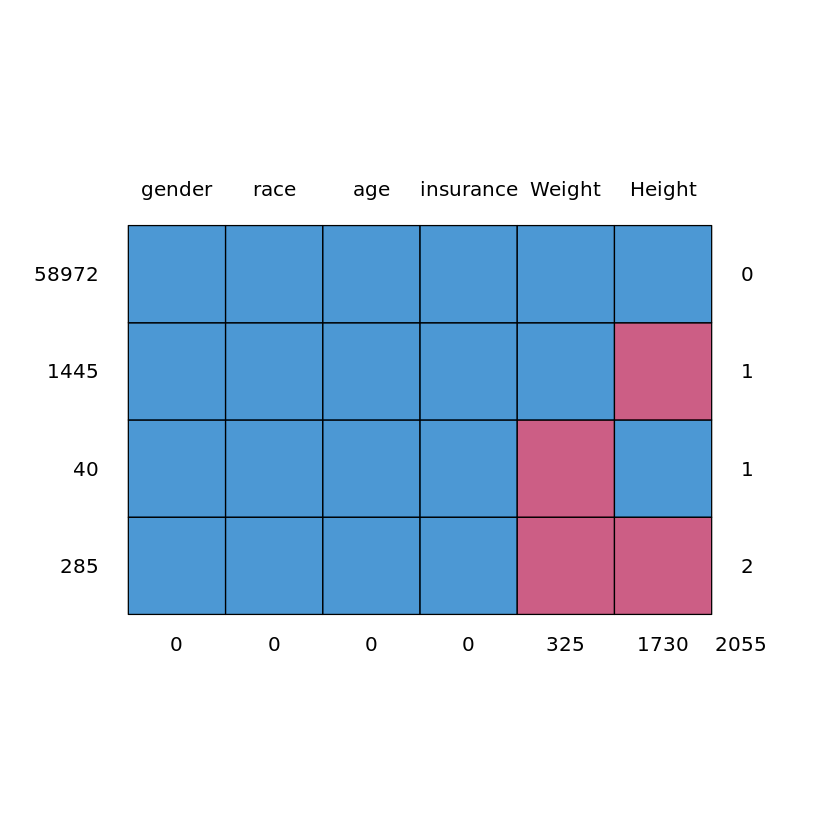

In [9]:
# this takes awhile(~2min), set seed = 123
# only impute 3 time, predictive mean matching with k=10

hw <- demo_hw %>% select(gender, race, age, insurance, Height, Weight)

md.pattern(hw)
hw_mice <- mice(hw, m=3, donors=10, maxit=50, meth='pmm', seed=123)

Warning message in plot.aggr(res, ...):
“not enough horizontal space to display frequencies”



 Variables sorted by number of missings: 
                Variable       Count
                     ESI 0.029633532
                  Height 0.028481117
                  Weight 0.005350499
                 anon_id 0.000000000
    pat_enc_csn_id_coded 0.000000000
                   label 0.000000000
              admit_time 0.000000000
 inpatient_data_id_coded 0.000000000
                  gender 0.000000000
                    race 0.000000000
               insurance 0.000000000
                     age 0.000000000
                 English 0.000000000


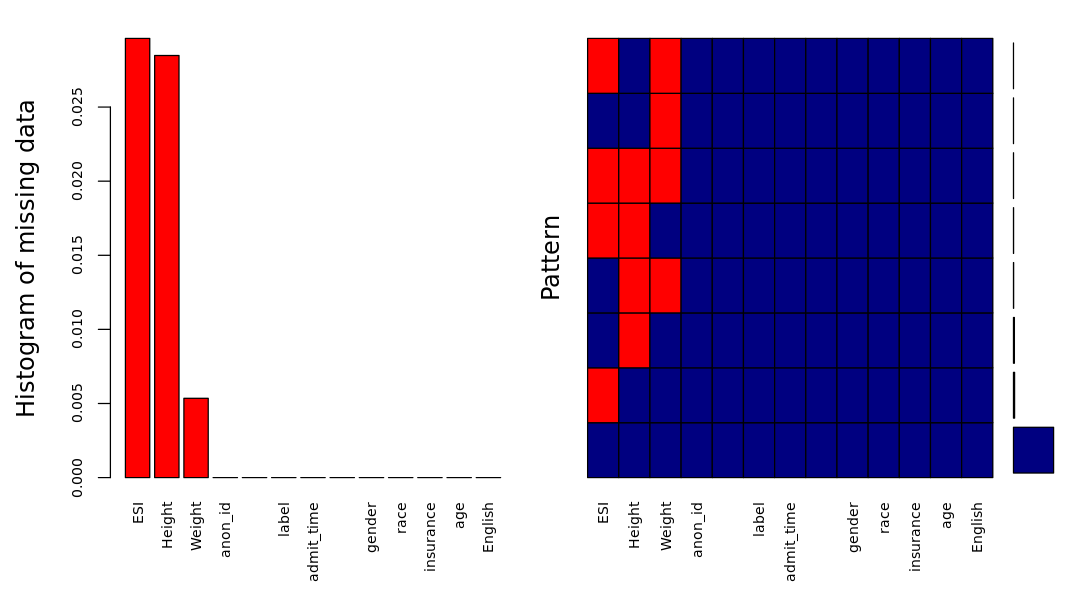

In [10]:
options(repr.plot.width=9, repr.plot.height=5)
aggr_plot <- aggr(demo_hw, col=c('navyblue','red'), numbers=TRUE, sortVars=TRUE, 
                  labels=names(demo_hw), cex.axis=.7, gap=3, ylab=c("Histogram of missing data","Pattern"))

In [11]:
# note: no pooling of results from analysis of multiply imputed dataset
# chose the 2nd set. can also do a random number each time

hw_mice2 <- complete(hw_mice, 2)
summary(hw_mice2)
colnames(hw_mice2)

    gender              race                age           insurance     
 Length:60742       Length:60742       Min.   : 18.00   Min.   :0.0000  
 Class :character   Class :character   1st Qu.: 45.00   1st Qu.:0.0000  
 Mode  :character   Mode  :character   Median : 61.00   Median :0.0000  
                                       Mean   : 58.62   Mean   :0.4221  
                                       3rd Qu.: 73.00   3rd Qu.:1.0000  
                                       Max.   :107.00   Max.   :1.0000  
     Height          Weight      
 Min.   :115.0   Min.   : 20.50  
 1st Qu.:160.0   1st Qu.: 61.10  
 Median :168.0   Median : 73.71  
 Mean   :168.1   Mean   : 77.06  
 3rd Qu.:175.3   3rd Qu.: 88.30  
 Max.   :213.0   Max.   :322.00  

[1] "gender"    "race"      "age"       "insurance" "Height"    "Weight"

In [12]:
nrow(hw_mice2) #45796

# here: keep bind the old set with the imputed set, just to compare
hw_mice2 <- hw_mice2 %>% select(Height, Weight) %>% 
                    rename(Height_i = Height, Weight_i = Weight)

hw_imputed <- bind_cols(demo_hw, hw_mice2) 
colnames(hw_imputed)

[1] 60742

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "label"                   "admit_time"             
 [5] "inpatient_data_id_coded" "ESI"                    
 [7] "gender"                  "race"                   
 [9] "insurance"               "age"                    
[11] "English"                 "Height"                 
[13] "Weight"                  "Height_i"               
[15] "Weight_i"

In [13]:
head(hw_imputed, n=1)

,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,insurance,age,English,Height,Weight,Height_i,Weight_i
,<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,JC29f8ad2,131274729058,0,2019-08-31 12:52:00,40679773,3,Female,White,1,52,1,165,81,165,81


In [14]:
# 2 = we have both the original values and the imputed values in this same dataset, 
# but it doesn't have the indicators of missingness
hw_imputed <- hw_imputed %>% 
                select(c(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, label, admit_time, ESI, 
                         gender, race, age, insurance, English, Height, Height_i, Weight, Weight_i)) %>% 
                mutate(delta_H = ifelse(is.na(Height), 1, 0),
                       delta_W = ifelse(is.na(Weight), 1, 0)) %>%
                select(-c(Height, Weight))
summary(hw_imputed %>% select(delta_H, delta_W))
colnames(hw_imputed)

    delta_H           delta_W        
 Min.   :0.00000   Min.   :0.000000  
 1st Qu.:0.00000   1st Qu.:0.000000  
 Median :0.00000   Median :0.000000  
 Mean   :0.02848   Mean   :0.005351  
 3rd Qu.:0.00000   3rd Qu.:0.000000  
 Max.   :1.00000   Max.   :1.000000  

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "label"                  
 [5] "admit_time"              "ESI"                    
 [7] "gender"                  "race"                   
 [9] "age"                     "insurance"              
[11] "English"                 "Height_i"               
[13] "Weight_i"                "delta_H"                
[15] "delta_W"

In [15]:
cohort3_demoHW <- left_join(cohort3, hw_imputed) # by=c('anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded'))
nrow(cohort3_demoHW) # 60742
nrow(cohort3_demoHW %>% select(pat_enc_csn_id_coded) %>% distinct()) #44258
colnames(cohort3_demoHW)

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded", "admit_time", "label")



[1] 60742

[1] 60742

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "DBP"                    
 [7] "Pulse"                   "RR"                     
 [9] "SBP"                     "Temp"                   
[11] "ESI"                     "gender"                 
[13] "race"                    "age"                    
[15] "insurance"               "English"                
[17] "Height_i"                "Weight_i"               
[19] "delta_H"                 "delta_W"

### Imputation for ESI
ESI -- from acuity_level encounter table
- use first vital values from vitals_clean to impute ESI
- this require the vitals_clean dataset to be done
- cohort with a complete set of vs: 1_3_cohort has the 1st completed vs set

[1] 60742

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   2.000   3.000   2.631   3.000   5.000    1800 

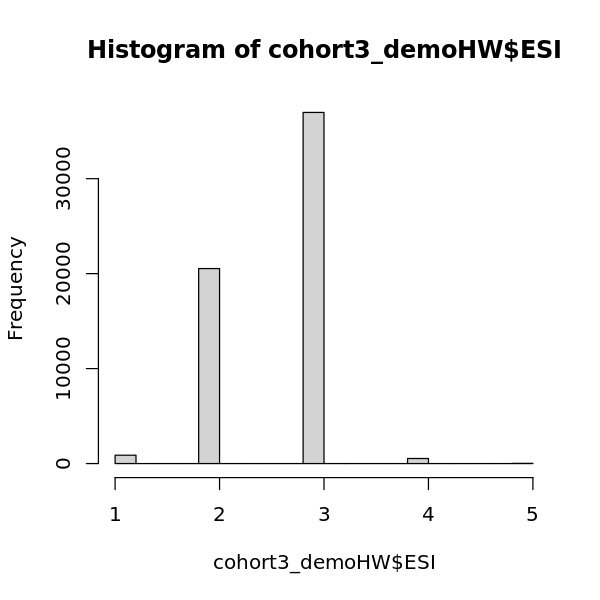

In [16]:
# missing ESI: 1718 (3.88%)
options(repr.plot.width=5, repr.plot.height=5)

nrow(cohort3_demoHW) #44258
summary(cohort3_demoHW$ESI)
hist(cohort3_demoHW$ESI)

In [17]:
# missing ESI per label
cohort3_demoHW %>% group_by(ESI, label) %>% count() %>% group_by(ESI) %>% mutate(p = round(100* n/sum(n), 2))

ESI,label,n,p
<int>,<int>,<int>,<dbl>
1,0,221,25.11
1,1,659,74.89
2,0,16337,79.56
2,1,4198,20.44
3,0,34487,93.27
3,1,2487,6.73
4,0,486,91.35
4,1,46,8.65
5,0,19,90.48


In [18]:
(1017 + 783)/60742 * 100 # missing ESI 2.96%

[1] 2.963353

,gender,race,age,insurance,Height_i,Weight_i,SBP,DBP,Pulse,RR,Temp,ESI,
58942,1,1,1,1,1,1,1,1,1,1,1,1,0
1800,1,1,1,1,1,1,1,1,1,1,1,0,1
,0,0,0,0,0,0,0,0,0,0,0,1800,1800



 iter imp variable
  1   1  ESI
  1   2  ESI
  1   3  ESI
  2   1  ESI
  2   2  ESI
  2   3  ESI
  3   1  ESI
  3   2  ESI
  3   3  ESI
  4   1  ESI
  4   2  ESI
  4   3  ESI
  5   1  ESI
  5   2  ESI
  5   3  ESI
  6   1  ESI
  6   2  ESI
  6   3  ESI
  7   1  ESI
  7   2  ESI
  7   3  ESI
  8   1  ESI
  8   2  ESI
  8   3  ESI
  9   1  ESI
  9   2  ESI
  9   3  ESI
  10   1  ESI
  10   2  ESI
  10   3  ESI
  11   1  ESI
  11   2  ESI
  11   3  ESI
  12   1  ESI
  12   2  ESI
  12   3  ESI
  13   1  ESI
  13   2  ESI
  13   3  ESI
  14   1  ESI
  14   2  ESI
  14   3  ESI
  15   1  ESI
  15   2  ESI
  15   3  ESI
  16   1  ESI
  16   2  ESI
  16   3  ESI
  17   1  ESI
  17   2  ESI
  17   3  ESI
  18   1  ESI
  18   2  ESI
  18   3  ESI
  19   1  ESI
  19   2  ESI
  19   3  ESI
  20   1  ESI
  20   2  ESI
  20   3  ESI
  21   1  ESI
  21   2  ESI
  21   3  ESI
  22   1  ESI
  22   2  ESI
  22   3  ESI
  23   1  ESI
  23   2  ESI
  23   3  ESI
  24   1  ESI
  24   2  ESI
  24   3  ESI

Warning message:
“Number of logged events: 2”


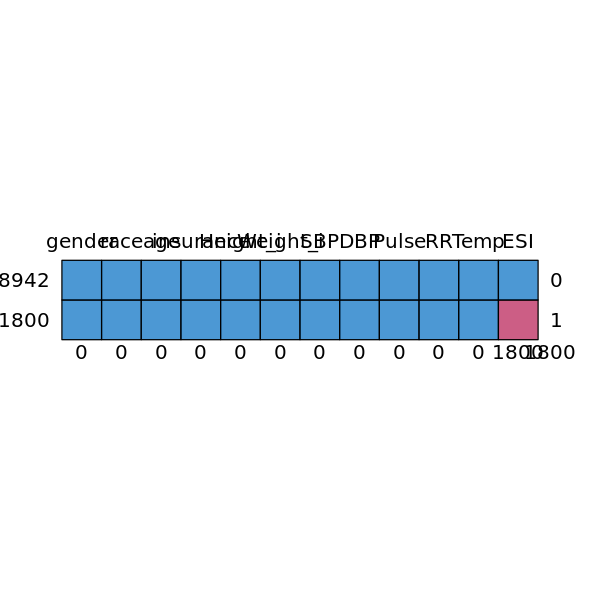

In [19]:
# m = 5 is the default --> takes too long
# meth='pmm' refers to the imputation method, predictive mean matching
# complete(, returns the 2nd completed data set)

esi <- cohort3_demoHW %>% select(ESI, gender, race, age, insurance, Height_i, Weight_i, SBP, DBP, Pulse, RR, Temp)
md.pattern(esi)
esi_mice <- mice(esi, m=3, donors=10, maxit=50, meth='pmm', seed=123)

In [20]:
esi_mice2 <- complete(esi_mice, 2)
summary(esi_mice2)
colnames(esi_mice2)

      ESI           gender              race                age        
 Min.   :1.000   Length:60742       Length:60742       Min.   : 18.00  
 1st Qu.:2.000   Class :character   Class :character   1st Qu.: 45.00  
 Median :3.000   Mode  :character   Mode  :character   Median : 61.00  
 Mean   :2.631                                         Mean   : 58.62  
 3rd Qu.:3.000                                         3rd Qu.: 73.00  
 Max.   :5.000                                         Max.   :107.00  
   insurance         Height_i        Weight_i           SBP       
 Min.   :0.0000   Min.   :115.0   Min.   : 20.50   Min.   : 37.0  
 1st Qu.:0.0000   1st Qu.:160.0   1st Qu.: 61.10   1st Qu.:116.0  
 Median :0.0000   Median :168.0   Median : 73.71   Median :131.0  
 Mean   :0.4221   Mean   :168.1   Mean   : 77.06   Mean   :132.9  
 3rd Qu.:1.0000   3rd Qu.:175.3   3rd Qu.: 88.30   3rd Qu.:148.0  
 Max.   :1.0000   Max.   :213.0   Max.   :322.00   Max.   :419.0  
      DBP             Pulse

[1] "ESI"       "gender"    "race"      "age"       "insurance" "Height_i" 
 [7] "Weight_i"  "SBP"       "DBP"       "Pulse"     "RR"        "Temp"

In [21]:
colnames(cohort3_demoHW)

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "DBP"                    
 [7] "Pulse"                   "RR"                     
 [9] "SBP"                     "Temp"                   
[11] "ESI"                     "gender"                 
[13] "race"                    "age"                    
[15] "insurance"               "English"                
[17] "Height_i"                "Weight_i"               
[19] "delta_H"                 "delta_W"

In [22]:
nrow(esi_mice2) #45796

# here: keep bind the old set with the imputed set, just to compare
esi_mice2 <- esi_mice2 %>% select(ESI_i=ESI)

esi_imputed <- bind_cols(cohort3_demoHW, esi_mice2) %>% mutate(delta_ESI = ifelse(is.na(ESI), 1, 0))
colnames(esi_imputed)

[1] 60742

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "DBP"                    
 [7] "Pulse"                   "RR"                     
 [9] "SBP"                     "Temp"                   
[11] "ESI"                     "gender"                 
[13] "race"                    "age"                    
[15] "insurance"               "English"                
[17] "Height_i"                "Weight_i"               
[19] "delta_H"                 "delta_W"                
[21] "ESI_i"                   "delta_ESI"

In [23]:
# rearrange all the columns 
cohort3_imp <-  esi_imputed %>% select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, admit_time, label,
                                      ESI_i, delta_ESI, gender, race, age, insurance, English,  
                                      Height_i, delta_H, Weight_i, delta_W)
dim(cohort3_imp)
summary(cohort3_imp %>% select(ESI_i, delta_ESI, Height_i, delta_H, Weight_i, delta_W))

[1] 60742    16

     ESI_i         delta_ESI          Height_i        delta_H       
 Min.   :1.000   Min.   :0.00000   Min.   :115.0   Min.   :0.00000  
 1st Qu.:2.000   1st Qu.:0.00000   1st Qu.:160.0   1st Qu.:0.00000  
 Median :3.000   Median :0.00000   Median :168.0   Median :0.00000  
 Mean   :2.631   Mean   :0.02963   Mean   :168.1   Mean   :0.02848  
 3rd Qu.:3.000   3rd Qu.:0.00000   3rd Qu.:175.3   3rd Qu.:0.00000  
 Max.   :5.000   Max.   :1.00000   Max.   :213.0   Max.   :1.00000  
    Weight_i         delta_W        
 Min.   : 20.50   Min.   :0.000000  
 1st Qu.: 61.10   1st Qu.:0.000000  
 Median : 73.71   Median :0.000000  
 Mean   : 77.06   Mean   :0.005351  
 3rd Qu.: 88.30   3rd Qu.:0.000000  
 Max.   :322.00   Max.   :1.000000  

### One hot coding for gender and race
* Gender: simply 1 for female and 0 for male
* Race: one-hot coding as usual

In [24]:
# 1 for female and 0 for male:
cohort3_imp <- cohort3_imp %>% mutate(gender = ifelse(gender == "Male", 0, 1),
                                      race =  as.factor(race))

In [25]:
colnames(cohort3_imp)

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "ESI_i"                  
 [7] "delta_ESI"               "gender"                 
 [9] "race"                    "age"                    
[11] "insurance"               "English"                
[13] "Height_i"                "delta_H"                
[15] "Weight_i"                "delta_W"

In [26]:
# onehot coding for race: (caret package for dummyVars)
dummy <- dummyVars(~ race, data = cohort3_imp) # if more ! gender + race
race_1hot <- data.frame(predict(dummy, newdata = cohort3_imp))
cohort3_imp <-  cohort3_imp %>% select(-race) %>% bind_cols(race_1hot)
dim(cohort3_imp)
summary(cohort3_imp)

[1] 60742    22

   anon_id          pat_enc_csn_id_coded inpatient_data_id_coded
 Length:60742       Min.   :1.311e+11    Min.   :13616753       
 Class :character   1st Qu.:1.312e+11    1st Qu.:22649907       
 Mode  :character   Median :1.313e+11    Median :32875482       
                    Mean   :1.312e+11    Mean   :37411645       
                    3rd Qu.:1.313e+11    3rd Qu.:54248675       
                    Max.   :1.313e+11    Max.   :73231043       
   admit_time                      label            ESI_i      
 Min.   :2015-01-01 08:24:00   Min.   :0.0000   Min.   :1.000  
 1st Qu.:2016-12-17 03:34:15   1st Qu.:0.0000   1st Qu.:2.000  
 Median :2018-11-07 01:46:30   Median :0.0000   Median :3.000  
 Mean   :2018-08-29 13:12:23   Mean   :0.1346   Mean   :2.631  
 3rd Qu.:2020-06-02 23:38:15   3rd Qu.:0.0000   3rd Qu.:3.000  
 Max.   :2021-09-30 07:00:00   Max.   :1.0000   Max.   :5.000  
   delta_ESI           gender            age           insurance     
 Min.   :0.00000   Min.   :

In [27]:
head(cohort3_imp, n=3)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,ESI_i,delta_ESI,gender,age,insurance,English,Height_i,delta_H,Weight_i,delta_W,race.Asian,race.Black,race.Native.American,race.Other,race.Pacific.Islander,race.Unknown,race.White
,<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,JC29f8ad2,131274729058,40679773,2019-08-31 12:52:00,0,3,0,1,52,1,1,165.0,0,81.0,0,0,0,0,0,0,0,1
2,JC29f8ad3,131278291027,42992239,2019-10-05 23:48:00,0,3,0,1,35,1,1,163.0,1,83.0,1,1,0,0,0,0,0,0
3,JC29f8b9c,131266787806,36261582,2019-05-05 01:07:00,0,2,0,0,59,0,0,152.4,1,61.4,1,0,0,0,0,0,1,0


In [28]:
### complete final cohort from cohort4
cohort_imp <- cohort3_imp %>% filter(pat_enc_csn_id_coded %in% cohort4$pat_enc_csn_id_coded)
nrow(cohort_imp) # 60464
nrow(cohort_imp %>% select(pat_enc_csn_id_coded) %>% distinct()) # 60464

[1] 60464

[1] 60464

In [31]:
colnames(cohort_imp)

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "ESI_i"                  
 [7] "delta_ESI"               "gender"                 
 [9] "age"                     "insurance"              
[11] "English"                 "Height_i"               
[13] "delta_H"                 "Weight_i"               
[15] "delta_W"                 "race.Asian"             
[17] "race.Black"              "race.Native.American"   
[19] "race.Other"              "race.Pacific.Islander"  
[21] "race.Unknown"            "race.White"

In [32]:
# save file
write.csv(cohort_imp, file.path(valdir, "6_8_coh4_all_imputedHWESI.csv"), row.names=FALSE)